##### [sample solution that works]

# This tutorial is will bring you through your first deep reinforcement learning model


* Seaquest game as an example
* Training a simple lasagne neural network for Q_learning objective


## About OpenAI Gym

* Its a recently published platform that basicly allows you to train agents in a wide variety of environments with near-identical interface.
* This is twice as awesome since now we don't need to write a new wrapper for every game
* Go check it out!
  * Blog post - https://openai.com/blog/openai-gym-beta/
  * Github - https://github.com/openai/gym


## New to Lasagne and AgentNet?
* We only require surface level knowledge of theano and lasagne, so you can just learn them as you go.
* Alternatively, you can find Lasagne tutorials here:
 * Official mnist example: http://lasagne.readthedocs.io/en/latest/user/tutorial.html
 * From scratch: https://github.com/ddtm/dl-course/tree/master/Seminar4
 * From theano: https://github.com/craffel/Lasagne-tutorial/blob/master/examples/tutorial.ipynb
* This is pretty much the basic tutorial for AgentNet, so it's okay not to know it.


# Experiment setup
* Here we basically just load the game and check that it works

In [1]:
#global params.

#game title. full list of games = http://yavar.naddaf.name/ale/list_of_current_games.html
GAME="alien"

#game image will be resized from (210,160) to your image_size. 
#You may want a bigger image for your homework assignment IF you want a larger NN
IMAGE_W,IMAGE_H = IMAGE_SIZE =(105,80)

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 10
SEQ_LENGTH = 5

In [2]:
from __future__ import print_function 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%env THEANO_FLAGS="floatX=float32"

env: THEANO_FLAGS="floatX=float32"


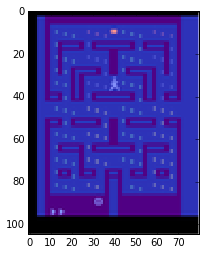

In [3]:
from env import Atari

#creating a game
atari = Atari(GAME,image_size=IMAGE_SIZE) 

action_names = np.array(atari.get_action_meanings())

obs = atari.step(0)[0]

plt.imshow(obs,interpolation='none')

# Basic agent setup
Here we define a simple agent that maps game images into Qvalues using simple convolutional neural network.

![scheme](https://s18.postimg.org/gbmsq6gmx/dqn_scheme.png)

In [4]:
import lasagne

In [5]:
from lasagne.layers import InputLayer, DimshuffleLayer,ExpressionLayer

#image observation at current tick goes here, shape = (sample_i,x,y,color)
observation_layer = InputLayer((None,IMAGE_W,IMAGE_H,3))

observation_grayscale = ExpressionLayer(observation_layer,
                                        lambda a: a.mean(axis=-1),
                                        output_shape=lambda shape: shape[:-1])


In [6]:
from agentnet.memory import WindowAugmentation,LSTMCell,RNNCell

#store 4-tick window in order to perceive motion of objects

prev_window = InputLayer([None,4,IMAGE_W,IMAGE_H])

current_window = WindowAugmentation(observation_grayscale,prev_window)

In [7]:
from lasagne.layers import Conv2DLayer,Pool2DLayer,DenseLayer,batch_norm,dropout

#main neural network body
conv0 = Conv2DLayer(current_window,16,filter_size=(8,8),stride=(4,4),name='conv0')

conv1 = Conv2DLayer(batch_norm(conv0),32,filter_size=(4,4),stride=(2,2),name='conv1')

conv2 = Conv2DLayer(batch_norm(conv1),64,filter_size=(4,4),stride=(2,2),name='conv2')

dense0 = DenseLayer(batch_norm(conv2),256,name='dense',nonlinearity = lasagne.nonlinearities.tanh)

#please set this to your last layer for convenience
last_layer = dense0

In [8]:
#a layer that predicts Qvalues
qvalues_layer = DenseLayer(last_layer,
                   num_units = atari.action_space.n,
                   nonlinearity=lasagne.nonlinearities.linear,
                   name="q-evaluator layer")

#To pick actions, we use an epsilon-greedy resolver (epsilon is a property)
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer,name="e-greedy action picker")

action_layer.epsilon.set_value(np.float32(0.1))


##### Finally, agent
We declare that this network is and MDP agent with such and such inputs, states and outputs

In [9]:
from agentnet.agent import Agent
#all together
agent = Agent(observation_layers=observation_layer,
              policy_estimators=qvalues_layer,
              agent_states={current_window:prev_window},
              action_layers=action_layer)


In [10]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[conv0.W,
 conv0_bn.beta,
 conv0_bn.gamma,
 conv1.W,
 conv1_bn.beta,
 conv1_bn.gamma,
 conv2.W,
 conv2_bn.beta,
 conv2_bn.gamma,
 dense.W,
 dense.b,
 q-evaluator layer.W,
 q-evaluator layer.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [11]:
from pool import AtariGamePool

pool = AtariGamePool(agent,GAME, N_AGENTS,image_size=IMAGE_SIZE,max_size=1000) #may need to adjust for speed


WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
[2016-11-01 01:02:35,664] We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [12]:
%%time
#interact for 7 ticks
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log][:2])
print(reward_log[:2])

[['DOWNLEFT' 'LEFTFIRE' 'LEFTFIRE' 'LEFTFIRE' 'LEFTFIRE' 'LEFTFIRE'
  'LEFTFIRE']
 ['DOWNLEFT' 'LEFTFIRE' 'LEFTFIRE' 'LEFTFIRE' 'LEFTFIRE' 'LEFTFIRE'
  'LEFTFIRE']]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]
CPU times: user 1.24 s, sys: 508 ms, total: 1.75 s
Wall time: 1.82 s


In [13]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# Q-learning
* An agent has a method that produces symbolic environment interaction sessions
* Such sessions are in sequences of observations, agent memory, actions, q-values,etc
  * one has to pre-define maximum session length.

* SessionPool also stores rewards (Q-learning objective)

In [14]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    optimize_experience_replay=True,
)



In [15]:
#get reference Qvalues according to Qlearning algorithm
from agentnet.learning import qlearning

#crop rewards to [-1,+1] to avoid explosion.
#import theano.tensor as T
#rewards = T.maximum(-1,T.minimum(rewards,1))

#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2

elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions,
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [16]:
# Compute weight updates
updates = lasagne.updates.adadelta(loss,weights,learning_rate=0.01)

In [17]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

In [18]:
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2016-11-01 01:06:35,155] Trying to monitor an environment which has no 'spec' set. This usually means you did not create it via 'gym.make', and is recommended only for advanced users.
[2016-11-01 01:06:35,157] Creating monitor directory ./records
[2016-11-01 01:06:35,293] Starting new video recorder writing to /home/jheuristic/Downloads/dqn_binder/records/openaigym.video.0.11586.video000000.mp4
[2016-11-01 01:07:27,421] Finished writing results. You can upload them to the scoreboard via gym.upload('/home/jheuristic/Downloads/dqn_binder/records')


Episode finished after 1405 timesteps with reward=860.0


In [19]:
from IPython.display import HTML

video_path="<the link to mp4 file from the cell above>"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Training loop

In [ ]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [ ]:

#the loop may take eons to finish.
#consider interrupting early.
for i in xrange(10**10):    
    
    
    #train
    pool.update(SEQ_LENGTH,append=True)
    
    for i in range(5):
        loss = train_step()
    
    ##update resolver's epsilon (chance of random action instead of optimal one)
    current_epsilon = 0.05 + 0.45*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(current_epsilon))
    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = pool.experience_replay.rewards.get_value().mean()
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f"%(epoch_counter,
                                                         current_epsilon,
                                                         pool_mean_reward))
        

    ##record current learning progress and show learning curves
    if epoch_counter%100 ==0:
        rewards[epoch_counter] = pool.evaluate(record_video=False)
        
        plt.title("random frames")
        for i in range(min((len(pool.games),6))):
            plt.subplot(2,3,i+1)
            plt.imshow(pool.games[i].get_observation())
        plt.show()

    
    epoch_counter  +=1

    
# Time to drink some coffee!

iter=10	epsilon=0.496	reward/step=0.45455


# Evaluating results
 * Here we plot learning curves and sample testimonials

In [ ]:
plt.plot(*zip(*sorted(list(rewards.items()),key=lambda p:p[0])))
    

In [ ]:
action_layer.epsilon.set_value(0.001)
rw = pool.evaluate(n_games=20,save_path="./records",record_video=False)
print("mean session score=%f.5"%rw)

In [ ]:
from IPython.display import HTML

#select the one you want
video_path="./records/openaigym.video.0.13.video000000.mp4"

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_path))


# Once you got it working,
Try building a network that maximizes the final score

* Moar lasagne stuff: convolutional layers, batch normalization, nonlinearities and so on
* Recurrent agent memory layers, GRUMemoryLayer, etc
* Different reinforcement learning algorithm (p.e. qlearning_n_step), other parameters
* Experience replay pool


Look for info?
* [lasagne doc](http://lasagne.readthedocs.io/en/latest/)
* [agentnet doc](http://agentnet.readthedocs.io/en/latest/)
* [gym homepage](http://gym.openai.com/)


You can also try to expand to a different game: 
 * all OpenAI Atari games are already compatible, you only need to change GAME_TITLE
 * Other discrete action space environments are also accessible this way
 * For continuous action spaces, either discretize actions or use continuous RL algorithms (e.g. .learning.dpg_n_step)
 * Adapting to a custom non-OpenAI environment can be done with a simple wrapper
 
 
__Good luck!__